# Example Juniper Question Report

In [34]:
from calitp.tables import tbl
from siuba import *
from siuba.sql import sql_raw
from plotnine import *

## Are feed expiration dates meaningful and reliable?

In [91]:
DATE_YEAR_AGO = "2020-07-12"
DATE_YEAR_OUT = "2022-07-12"


tbl_feed_info = (tbl.gtfs_schedule.feed_info() >>
  mutate(
      start_date = sql_raw('PARSE_DATE("%Y%m%d", feed_start_date)'),
      end_date = sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'),
      start_date_year_ago = _.start_date < DATE_YEAR_AGO,
      end_date_year_out = _.end_date > DATE_YEAR_OUT,
      date_diff_days=sql_raw("DATE_DIFF(end_date, start_date, DAY)"),
      date_diff_short=_.date_diff_days < 365
  )
)

In [94]:
tbl_expiration = (
    tbl_feed_info
    >> mutate(end_date_max=_.end_date.max(), start_date_min=_.start_date)
    >> summarize(
        end_date_max=_.end_date_max.max(),
        start_date_min=_.start_date_min.min(),        
        n_end_date_max=(_.end_date == _.end_date_max).astype(int).sum(),
        n_start_date_min=(_.end_date == _.end_date_max).astype(int).sum(),
        n_start_date_year=(_.start_date < DATE_YEAR_AGO).astype(int).sum(),
        n_end_date_year=(_.end_date > DATE_YEAR_OUT).astype(int).sum(),
        avg_date_diff=_.date_diff_days.mean().round(),
        n_date_diff_short=_.date_diff_short.astype(int).sum()
    )
)

In [106]:
df_expiration = tbl_expiration >> collect() 

df_expiration.melt()

,variable,value
0,end_date_max,2029-12-31
1,start_date_min,2012-02-01
2,n_end_date_max,1
3,n_start_date_min,1
4,n_start_date_year,19
5,n_end_date_year,8
6,avg_date_diff,327
7,n_date_diff_short,126


/Users/machow/.virtualenvs/calitp-py/lib/python3.8/site-packages/plotnine/layer.py:381: PlotnineWarning: position_stack : Removed 11 rows containing missing values.


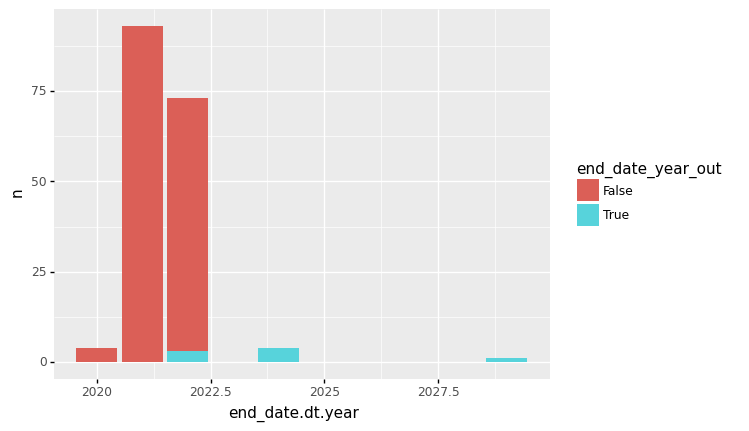

<ggplot: (303503240)>

In [74]:
# plot end date counts ----
(
    tbl_feed_info
    >> collect()
    >> mutate(end_date=_.end_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("end_date.dt.year", "n", fill="end_date_year_out")) + geom_col()
)

/Users/machow/.virtualenvs/calitp-py/lib/python3.8/site-packages/plotnine/layer.py:381: PlotnineWarning: position_stack : Removed 7 rows containing missing values.


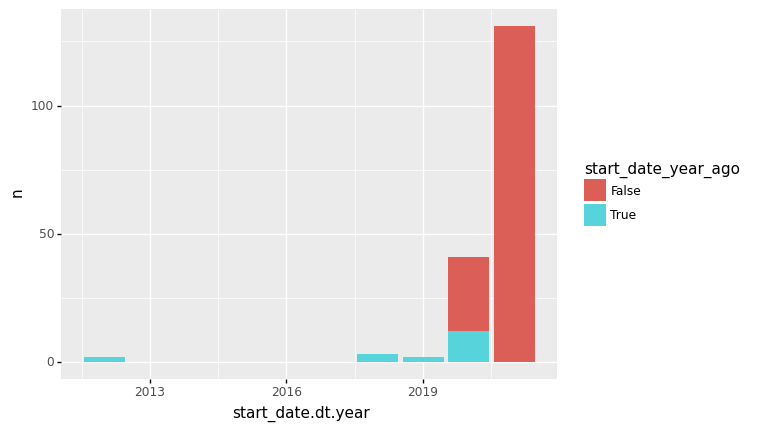

<ggplot: (303362545)>

In [76]:
(
    tbl_feed_info
    >> collect()
    >> mutate(start_date=_.start_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("start_date.dt.year", "n", fill="start_date_year_ago")) + geom_col()
)

## How many agencies have invalid GTFS data?

In [118]:
MONTH_START="2021-06-01"
MONTH_END="2021-06-30"

tbl_date_range = tbl.views.dim_date() >> filter(_.full_date.between(MONTH_START, MONTH_END)) >> select(_.full_date)

In [120]:
tbl_feed_info_daily = (
    tbl.gtfs_schedule_type2.feed_info()
    >> mutate(deleted_at=_.calitp_deleted_at.fillna("2099-01-01"))
    >> inner_join(
        _,
        tbl_date_range,
        sql_on=lambda lhs, rhs: (lhs.calitp_extracted_at <= rhs.full_date)
        & (lhs.deleted_at > rhs.full_date),
    )
)

In [123]:
(
    tbl_feed_info_daily
    >> mutate(
        start_date=sql_raw('PARSE_DATE("%Y%m%d", feed_start_date)'),
        end_date=sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'),
        start_date_year_ago=_.start_date < DATE_YEAR_AGO,
        end_date_year_out=_.end_date > DATE_YEAR_OUT,
        date_diff_days=sql_raw("DATE_DIFF(end_date, start_date, DAY)"),
        date_diff_short=_.date_diff_days < 365,
    )
    >> group_by(_.full_date)
    >> summarize(mean_date_diff=_.date_diff_days.mean())
)

,full_date,mean_date_diff
0,2021-06-14,308.165680
1,2021-06-23,317.331361
2,2021-06-11,308.165680
3,2021-06-27,325.398810
4,2021-06-24,324.597633
